In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from rikabplotlib.plot_utils import newplot

import torch
import zuko

In [2]:
# Physics Parameters
E0 = 500
R = 0.4



# Training Params
mode = "FORWARD" #"REVERSE"
epochs = 1250
batch_size = 256
lr = 1e-3
epsilon = 1e-9 # For numerical stability, can probably set to 0
auxiliary_params = 1 # Number of auxiliary parameters to use in the model, 0 has different behavior!
num_transforms = 3 # I think this is the number of layers?
hidden_features=(64, 64)
x_range = (-0.5, 1.5) # Range of x values to train on, should be at least as large as the support of the data


In [3]:
# Distribution Choices:

def Gaussian(x):

    mean = 0
    std = 1

    # Gaussian 
    p = 1/np.sqrt(2 * np.pi  * std**2) * np.exp(- (x - mean)**2 / 2 / std**2)
    return p



def Theta(x):
    return torch.where(x > 0, torch.ones_like(x), torch.zeros_like(x))

def alpha_s(scale):
    lambda_qcd = 0.2
    beta_0 = 11 - 2/3 * 3
    return 4 * np.pi / (beta_0 * torch.log(scale**2 / lambda_qcd**2))

def LO_angularity(lambda_, beta = 1):

    scale = E0 * torch.pow(lambda_, 1 / (beta))

    alpha_s_scale = alpha_s(scale)
    C_F = 4/3
    C_A = 3

    return -((2 * alpha_s_scale * C_F / (1 * np.pi * beta * R)) * torch.log(lambda_ ) / lambda_ * Theta(1 - lambda_) * Theta(lambda_))

def LL_angularity(lambda_, beta = 1):

    scale = E0 * torch.pow(lambda_, 1 / (beta))

    alpha_s_scale = alpha_s(scale)
    C_F = 4/3
    C_A = 3

    p = torch.nan_to_num(LO_angularity(lambda_, beta) * torch.exp(-1 * alpha_s_scale * C_F / (beta * R *  np.pi) * torch.pow(torch.log(lambda_), 2)) )

    return (p * Theta(lambda_) * Theta(1 - lambda_))


# Choice of target
target_p = LL_angularity

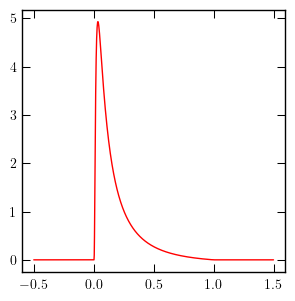

In [4]:
# Plot the target distribution

fig, ax = newplot("column")

xs = np.linspace(-0.5, 1.5, 1000)
ys = target_p(torch.tensor(xs)).detach().numpy()
ax.plot(xs, ys, label="LL Angularity", color = "red")


In [5]:
# Initialize the flow

# Can choose: NSF, MAF, NICE
flow = zuko.flows.NSF(features = auxiliary_params + 1, transforms= num_transforms, hidden_features=hidden_features)
optimizer = torch.optim.Adam(flow.parameters(), lr=lr)


pytorch_total_params = sum(p.numel() for p in flow.parameters() if p.requires_grad)
print(f"Numb. trainable params: {pytorch_total_params}")


Numb. trainable params: 22026


In [6]:
# Training Loop

PLOT_EACH_EPOCH = False
t = tqdm(range(epochs))
losses = []

for epoch in t:

    if mode == "REVERSE":



        xs = flow().sample((batch_size,1))
        logq = flow().log_prob(xs)
        logp = torch.nan_to_num(torch.log(target_p(xs))[:,:,0])


        loss = torch.nanmean((logq - logp))
        loss.backward()

    # Used to be called "REVERSE" / "No samples"
    if mode == "FORWARD":


        xs = torch.rand(batch_size, auxiliary_params + 1)  * (x_range[1] - x_range[0]) + x_range[0]

        # Auxillary variable -- uniform. alternatively set to const
        if auxiliary_params > 0:
            xs[:,1:] = torch.rand(batch_size, auxiliary_params)

        # Note for log_prob to work, we need to pass a tensor of shape (batch_size, 1)
        logq = flow().log_prob(xs)
        logp = torch.nan_to_num(torch.log(target_p(xs) + epsilon)[:,0])
        # technically need to adjust logp if aux is anything other than U(0,1)


        loss = torch.nanmean(torch.exp(logp) * ( - logq))
        loss.backward()

    if PLOT_EACH_EPOCH:
        if epoch % 1 == 0:
            fig, ax = newplot("column")

            ys = torch.exp(logp).detach().numpy()
            ax.scatter(xs[:,0], ys, label="Target", color = "red")

            ys = torch.exp(logq).detach().numpy()
            ax.scatter(xs[:,0], ys, label="Flow", color = "blue")
            plt.yscale("log")   
            plt.legend()

            plt.show()


    # Gradient Descent
    optimizer.step()
    optimizer.zero_grad()



    losses.append(loss.item())
    t.set_description(f"Loss: {loss.item()}")



  0%|          | 0/1250 [00:00<?, ?it/s]

Loss: -0.31872886419296265: 100%|██████████| 1250/1250 [01:51<00:00, 11.21it/s]


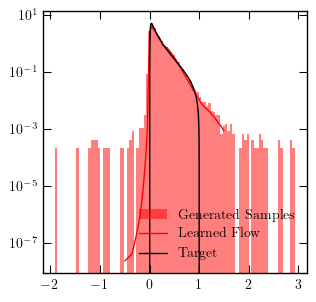

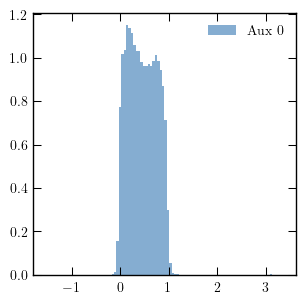

In [13]:
# Plot distribution of xs


samples = flow().sample((100000,))
x_samples = samples[:,0].detach().numpy()
aux_samples = samples[:,1:].detach().numpy()

fig, ax = newplot("column")

plt.hist(x_samples, bins=100, density=True, color = "red", alpha = 0.5, label = "Generated Samples")


xs = torch.zeros((1000, auxiliary_params + 1))
xs[:,0] = torch.linspace(-0.5, 1.5, 1000)
ys = flow().log_prob(xs).exp()

xs = xs[:,0].detach().numpy().flatten()
ys = ys.detach().numpy().flatten()
plt.plot(xs, ys, color = "red", label = "Learned Flow")


plt.plot(xs, target_p(torch.tensor(xs)), color = "Black", label = "Target")

plt.legend()

plt.yscale("log")

# plot the auxiliary variables
if auxiliary_params > 0:
    fig, ax = newplot("column")
    for i in range(auxiliary_params):
        plt.hist(aux_samples[:,i], bins=100, density=True, alpha = 0.5, label=f"Aux {i}")
        prob = flow().log_prob(samples).exp()
        # plt.scatter(aux_samples[:,i], prob.detach().numpy(), color = "red")
    plt.legend()

    


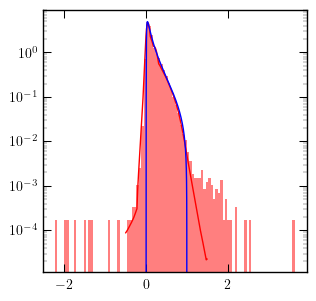

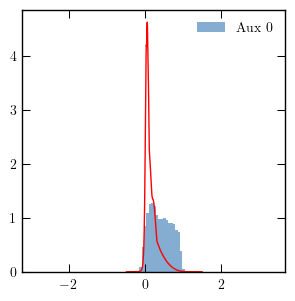

In [45]:
# #  Plot distribution of xs


# samples = flow().sample((100000,)).detach().numpy()
# x_samples = samples[:,0]
# aux_samples = samples[:,1:]

# fig, ax = newplot("column")

# plt.hist(x_samples, bins=100, density=True, color = "red", alpha = 0.5)


# xs = torch.zeros((1000, auxiliary_params + 1))
# xs[:,0] = torch.linspace(-0.5, 1.5, 1000)
# ys = flow().log_prob(xs).exp()

# xs = xs[:,0].detach().numpy().flatten()
# ys = ys.detach().numpy().flatten()
# plt.plot(xs, ys, color = "red")


# plt.plot(xs, target_p(torch.tensor(xs)), color = "blue")

# plt.yscale("log")

# # plot the auxiliary variables
# if auxiliary_params > 0:
#     fig, ax = newplot("column")
#     for i in range(auxiliary_params):
#         plt.hist(aux_samples[:,i], bins=100, density=True, alpha = 0.5, label=f"Aux {i}")
#         plt.plot(xs, ys, color = "red")
#     plt.legend()
